### `list_attr_celeba` Dataset
A popular component of computer vision and deep learning revolves around identifying faces for various applications from logging into your phone with your face or searching through surveillance images for a particular suspect. This dataset is great for training and testing models for face detection, particularly for recognising facial attributes such as finding people with brown hair, are smiling, or wearing glasses. Images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong (specific reference in Acknowledgment section).



- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image

You can obtain the dataset from https://www.kaggle.com/jessicali9530/celeba-dataset

In [58]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import keras
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Flatten

In [59]:
mypath=r"C:\Users\BalintStewart\OneDrive - Health Data Research\Desktop\magnimind non-github\DL practice assignments\gender_detection"
print(os.listdir(mypath))

df=pd.read_csv(r"C:\Users\BalintStewart\OneDrive - Health Data Research\Desktop\magnimind non-github\DL practice assignments\gender_detection\list_attr_celeba.csv\list_attr_celeba.csv")

df.head()
df.columns.values

['celeb_small 2', 'list_attr_celeba.csv']


array(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
       'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'], dtype=object)

#### See sample image

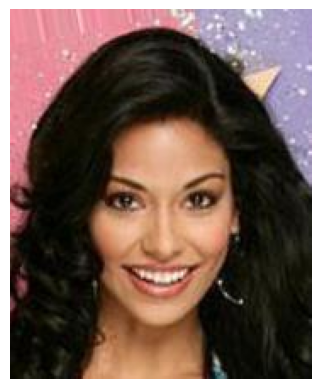

In [60]:
from PIL import Image
# Path to the directory 
image_dir = r"C:\Users\BalintStewart\OneDrive - Health Data Research\Desktop\magnimind non-github\DL practice assignments\gender_detection\celeb_small 2"

# Get a sample image file
sample_image_file = os.listdir(image_dir)[10]  # Adjust index to select a different image

# Open and display the image
image_path = os.path.join(image_dir, sample_image_file)
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')  # Hide axes for a cleaner display
plt.show()

### 4. Build Model

- First, copy VGG16 without the dense layers, use the weights from `imagenet`. Set the input shape to `(178,218,3)`.
- Freeze the layers except the last two layers and print to see if the layers are trainable or not.
- Build your sequential model (you are free to use a functioanl API as a further exercise). Include all the frozen VGG layers to your model. Add a Dense layer with 128 inouts and `relu` activation. Add a batch nomalizer, then a dense layer as the output layer. 
- Create an early stopping criteria monitorin the loss value for the validation set. Stop the search if the loss value deosnt change for two consecutive times.
- Compile the model.
- Save the best model automatically based on the performance of the validation set.

In [61]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(178, 218, 3))

# Freeze convolutional layers so they are not retrained
for layer in base_model.layers[:-2]:
    layer.trainable = False

for layer in base_model.layers:
    print(f"{layer.name}: Trainable = {layer.trainable}")

# Build your sequential model
model = Sequential()

model.add(base_model)

# Flatten the output of the convolutional layers
model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation = 'sigmoid'))


from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=2,  # Stop if loss doesn't improve for 2 consecutive epochs
    restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5.keras',  # Save the best model
    monitor='val_loss',  # Track validation loss
    save_best_only=True,  # Only save the model if it improves
    verbose=1
)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

model.summary()


input_layer_15: Trainable = False
block1_conv1: Trainable = False
block1_conv2: Trainable = False
block1_pool: Trainable = False
block2_conv1: Trainable = False
block2_conv2: Trainable = False
block2_pool: Trainable = False
block3_conv1: Trainable = False
block3_conv2: Trainable = False
block3_conv3: Trainable = False
block3_pool: Trainable = False
block4_conv1: Trainable = False
block4_conv2: Trainable = False
block4_conv3: Trainable = False
block4_pool: Trainable = False
block5_conv1: Trainable = False
block5_conv2: Trainable = False
block5_conv3: Trainable = True
block5_pool: Trainable = True


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     1,966,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,681,537 (63.64 MB)

 Trainable params: 4,326,401 (16.50 MB)

 Non-trainable params: 12,355,136 (47.13 MB)

## 5. Data Preparation

- Create a validation set with 20% of the data. Check the number of data points per class from both the train and validation sets.


In [62]:
# Add category labels to the training data
files = os.listdir(image_dir)
labelled_data = [{'filename': f, 'category': 'female' if f.startswith('female') else 'male'} for f in files]
df = pd.DataFrame(labelled_data)
df.sample(10)


,filename,category
1482,female.026344.jpg,female
2388,man.011984.jpg,male
284,female.004528.jpg,female
757,female.013445.jpg,female
863,female.015297.jpg,female
1888,female.034150.jpg,female
1028,female.018101.jpg,female
3215,man.032020.jpg,male
216,female.003287.jpg,female
1666,female.029890.jpg,female


- Set your batch size to 20.
- Create the data generator and set the `preprocessing_function` to `preprocess_input` of VGG16.
- Create train and validation data generators (batches will be picked up from the dataframe). Set target size to (178,218) (you can try something else, but you need to do the corresponding change in the model).
- Set your validation  and epoch step size (`validation_steps` and `steps_per_epoch`)

In [63]:
batch_size = 20

#shuffle the dataframe so that when doing train/val split we get good category split
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   validation_split = 0.2)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = df,
    directory = image_dir,
    x_col = 'filename',
    y_col = 'category',
    target_size = (178, 218),
    batch_size = batch_size,
    class_mode = 'binary',
    subset = 'training',
    shuffle = True
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe = df,
    directory = image_dir,
    x_col = 'filename',
    y_col = 'category',
    target_size = (178, 218),
    batch_size = batch_size,
    class_mode = 'binary',
    subset = 'validation',
    shuffle = True
)

Found 3041 validated image filenames belonging to 2 classes.
Found 760 validated image filenames belonging to 2 classes.


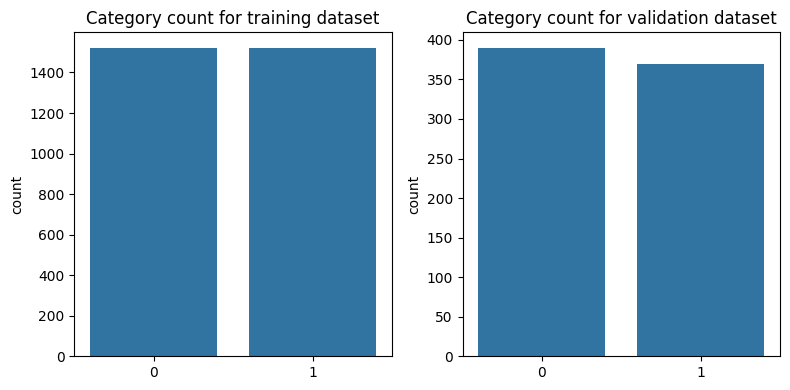

In [64]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
sns.countplot(x = train_generator.classes, ax = ax[0])
ax[0].set_title('Category count for training dataset')

sns.countplot(x = validation_generator.classes, ax = ax[1])
ax[1].set_title('Category count for validation dataset')
plt.tight_layout()
plt.show()

- Set your validation  and epoch step size (`validation_steps` and `steps_per_epoch`)

In [65]:
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

## 6. Train the Model

- Fit the model
- save the model

In [66]:
model.fit(train_generator,
          steps_per_epoch = steps_per_epoch,
          epochs = 50,
          validation_data = validation_generator,
          validation_steps = validation_steps,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/50


c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8673 - loss: 0.3507
Epoch 1: val_loss improved from inf to 0.19571, saving model to best_model.h5.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.8675 - loss: 0.3500 - val_accuracy: 0.9303 - val_loss: 0.1957
Epoch 2/50
  1/152 ━━━━━━━━━━━━━━━━━━━━ 3:08 1s/step - accuracy: 0.7500 - loss: 0.5613

c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.19571
152/152 ━━━━━━━━━━━━━━━━━━━━ 50s 326ms/step - accuracy: 0.7500 - loss: 0.5613 - val_accuracy: 0.9342 - val_loss: 0.2058
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9559 - loss: 0.1159
Epoch 3: val_loss improved from 0.19571 to 0.17388, saving model to best_model.h5.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.9559 - loss: 0.1160 - val_accuracy: 0.9355 - val_loss: 0.1739
Epoch 4/50
  1/152 ━━━━━━━━━━━━━━━━━━━━ 3:20 1s/step - accuracy: 0.9000 - loss: 0.1976
Epoch 4: val_loss improved from 0.17388 to 0.16198, saving model to best_model.h5.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 53s 340ms/step - accuracy: 0.9000 - loss: 0.1976 - val_accuracy: 0.9408 - val_loss: 0.1620
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9765 - loss: 0.0725
Epoch 5: val_loss did not improve from 0.16198
152/152 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.9765 - loss: 0.0726 - val_accuracy: 0.9145 - val_loss: 0.2

In [67]:
model.save_weights('model_weights.weights.h5')